# HW3

Submit via Slack. Due on Tuesday, April 13th, 2020, 6:29pm PST. You may work with one other person.

## TF-IDF

You are an analyst working at McDonalds as a store operations analyst, and charged with identifying areas for improvement for each franchise. Several metropolitan locations have been suffering recently from lower reviews.

Using the **mcdonalds-yelp-negative-reviews.csv** dataset, clean and parse the text reviews. Explain the decisions you make:
- why remove/keep stopwords?
- which stopwords to remove?
- stemming versus lemmatization?
- regex cleaning and substitution?
- adding in custom stopwords?
- what `n` for your `n-grams`?
- which words to collocate together?

Finally, generate a TF-IDF report that either **visualizes** or explains for a business (non-technical) stakeholder:
* the features your analysis showed that customers cited as reasons for a poor review
* the most common issues identified from your analysis that generated customer dissatisfaction.

Explain to what degree the TF-IDF findings make sense - what are its limitations?



In [1]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
import pandas as pd

In [2]:
# functions 

def word_count(lst):
    d = {}
    for line in lst:
        for word in line.split():
            d[word] = d.get(word,0) + 1
    return d


def remove_stopwords(lst, stopword_set):
    cleaned = []
    for line in lst:
        newline = []
        for word in line.split():
            if word.lower() in stopword_set:
                continue
            else:
                newline.append(word.lower())
        review = ' '.join(newline)
        cleaned.append(review)
    return cleaned


# lemmatized
def lemmatize_word(lst):
    lemma = WordNetLemmatizer()
    lemmatized = []
    for line in lst:
        new_line = []
        for word in line.split():
            new_word = lemma.lemmatize(word)
            new_line.append(new_word)
        sen = ' '.join(new_line)
        lemmatized.append(sen)
    return lemmatized

def replace_bigram_word(sentence):
    token_sentence = word_tokenize(sentence)
    for index, word in enumerate(token_sentence):
        combo = f'{token_sentence[index-1]}_{word}'
        if combo in top20_list:
            token_sentence[index-1] = combo
            token_sentence.pop(index)
    return(' '.join(token_sentence))

In [3]:
# Open and read the yelp reviews
reviews = pd.read_csv('mcdonalds-yelp-negative-reviews.csv', encoding='latin1')
lines = reviews['review'].tolist()


In [4]:
# Remove punctuation and the ID of each reviews using regex
regex = re.compile(r'[^\w\s\'\:]')
regex_digit = re.compile(r'\b\d{5,}\b')

lst = []
for line in lines:
    new_line = regex.sub(' ',line)
    new_line = regex_digit.sub('',new_line)
    lst.append(new_line)

In [5]:
# Remove stopwords using customized stopword set
stopword_set = set(stopwords.words('english'))
added = ['mcdonald\'s','mcdonalds','mcdonald','mcds','mcd\'s','i\'m','i\'ve',\
         'really','also','even','always','sometimes','right','every','going',\
         'aaaaaaaahhhhhhhhhhh','','yet','oh']

stopword_set.update(added)
stopword_set.difference_update({'not', "aren't", "couldn't",
                                "didn't", "doesn't", "don't", 
                                "hasn't", "wouldn't", "shouldn't"})

cleanned_lst = remove_stopwords(lst, stopword_set)

In [6]:
# Lemmatize the sentence
final_lst = lemmatize_word(cleanned_lst)

In [7]:
# Replace Collocation Bigrams
all_words = [r.split() for r in final_lst]
collo = BigramCollocationFinder.from_documents(all_words)
measures = BigramAssocMeasures()
top20_bigrams = collo.nbest(measures.raw_freq,20)
top20_list = []
for combo in top20_bigrams:
    top20_list.append(f'{combo[0]}_{combo[1]}')

In [8]:
collo_final_lst = [replace_bigram_word(r) for r in final_lst]

In [9]:
# Calculate TF-IFD for each document try bigram first
vectorizer = TfidfVectorizer(ngram_range=(2,2),
                             max_df=0.2)

X = vectorizer.fit_transform(final_lst)
features = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray().transpose(), index=features)

tf_idf = tf_idf.sum(axis=1)
score = pd.DataFrame(tf_idf, columns = ['score'])
score.sort_values(by = 'score', inplace=True, ascending=False)

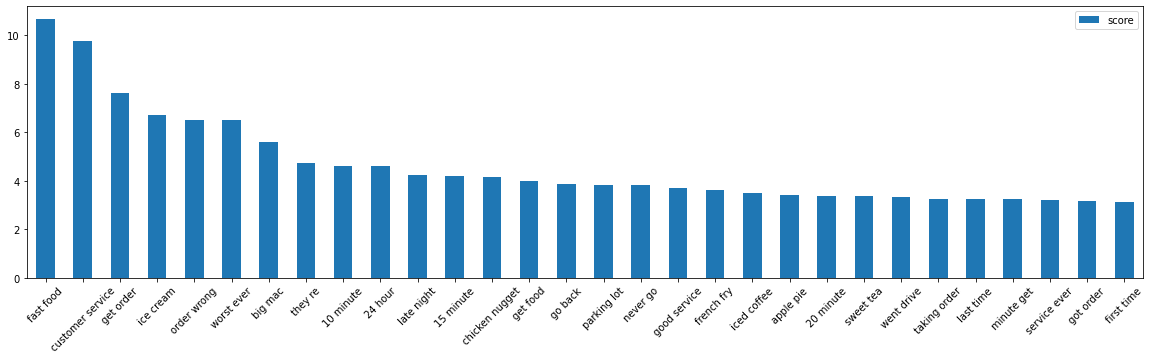

In [10]:
#TF-IDF report (bi-gram)
score.iloc[:30].plot(kind='bar',figsize =(20,5), rot=45)

In [11]:
# Calculate TF-IFD for each document trigrams
vectorizer = TfidfVectorizer(ngram_range=(3,3),
                             max_df=0.2)

X = vectorizer.fit_transform(final_lst)
features = vectorizer.get_feature_names()
tf_idf = pd.DataFrame(X.toarray().transpose(), index=features)

tf_idf = tf_idf.sum(axis=1)
score = pd.DataFrame(tf_idf, columns = ['score'])
score.sort_values(by = 'score', inplace=True, ascending=False)

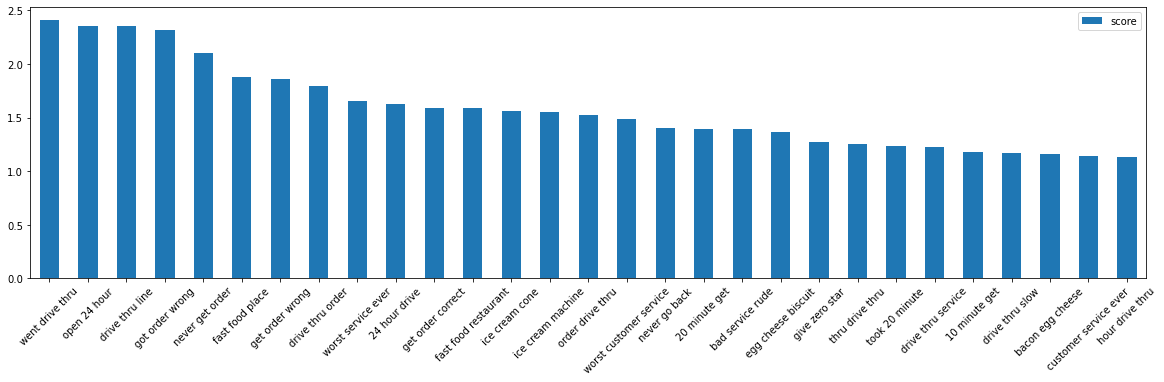

In [12]:
#TF-IDF report (tri-grams)
score.iloc[1:30].plot(kind='bar',figsize =(20,5), rot=45)

In [13]:
# Example analysis on frequent phases 1
res = []

for line in lst:
    if 'drive thru line' in line:
        res.append(line)
res

['My order was fresh and prepared correctly  They were friendly and moved the drive thru line quickly during the lunch rush  Very good ',
 "Years of pathetic service  disgusting food  and dangerous mistakes  Why do I keep going back Having nothing to do with Mcdonalds food in general and more to do with the ability of this specific location to produce it with out killing anybody  I have been going to this particular store for years  It is right around the corner from where I used to live  and is on the way from where I live to pretty much everything I use  gas station  costco  movie theater  market  etc   It is the only convenient location  and for a while Mcdonalds was the only place that had  1 drinks  So those are my lame excuses for repeatedly torturing myself with this horrible place  Service: I used to be a manager with another fast food chain  I know what service SHOULD be  I also know what it usually is  It doesn't have to be 5 star  But the rude attitudes  ridiculously slow se

In [14]:
# Example analysis on frequent phases 2
res = []

for line in lst:
    if 'ice cream machine' in line:
        res.append(line)
res

["The ice cream machine is always  down  after 11 p m  If you want a hot fudge sundae  don't even bother ",
 "This is the worst McDonald's I have ever been to Yes  there ARE better McD's out there  Like the one on Boulder Highway by Joker's Wild  right before you hit Warm Springs I have visited the last two nights here    Because I was picking up a friend of mine who got off from work  and we had a sweet tooth     along with my family members at the house Yesterday  we pull up and ask for hot fudge sundaes  Ice cream machine is out Instead  we get two large sweet teas     Which were overly sweet  Almost   gave off a syrup feel after I swallowed Tonight  the ice cream machine IS working  so I get two sundaes  and of course  two large sweet teas Sundaes look sad  because they are not in their proper clear plastic cup   they are instead in mini McFlurry cups     not even filled completely  might I add  My friend and I take one sip of our sweet teas    and they taste like dirty water It's 

### Conclusion for Q1


Using the **mcdonalds-yelp-negative-reviews.csv** dataset, clean and parse the text reviews. Explain the decisions you make:
- why remove/keep stopwords?
- which stopwords to remove?
- stemming versus lemmatization?
- regex cleaning and substitution?
- adding in custom stopwords?
- what `n` for your `n-grams`?
- which words to collocate together?

Finally, generate a TF-IDF report that either **visualizes** or explains for a business (non-technical) stakeholder:
* the features your analysis showed that customers cited as reasons for a poor review
* the most common issues identified from your analysis that generated customer dissatisfaction.

Explain to what degree the TF-IDF findings make sense - what are its limitations?

First, I will explain the decisions I made when cleanning this reviews dataset. 

I removed all the punctuation at the beginning of the process, except "'" and ":". I decide to keep these two punctuations because they usually denote a negation word or time, which can be useful for our analysis. I also removed words with only digits longer than 5 digits, because those numbers usually don't have any meaning. 

Then, I remove stopwords. Even though removing stopwords might introduce some weird combination when using N grams, but it can reduce the dimensinality of the dataset by eliminating the phases that contains stopwords. I customize the stopword set by adding additional stopwords such as "mcdonalds", "always", "sometimes", and etc.. Those words won't affect the meaning of the sentences. At the same time, I eliminate negation words such as "not" and "shouldn't" from the set, because when performing tri-grams, I don't want the meaning of the trigrams changed.

In this analysis, I chose lemmatization over stemming, because lemmatization can keep the meaning of the words. Since we would like to know what is the major reasons that people critize Mcdonalds, using lemmatization can help us to understand the sentence better.

I tried both bi and tri grams. According to the result that I got, tri-grams provide more infomation that we want. So I will conclude that trigrams has a better performance on this dataset. 

The word "drive" and "thru" are most frequently collocate together.

Next, I will talk about the findings obtained from this excercise. 

The TF-IDF report for trigrams returns phrases such as "drive thru line", "ice cream machine", "get order wrong" as the phrase with highest scores. The phrase "get order wrong" is pretty intuitive, it suggest that one major reason lead to negative reviews is that Mcdonalds often messes up with the orders. For the other phrases, I extracted all the reviews contains the phrase "drive thru line" and "ice cream machine", and manually reviewed them. The problem with drive-thru is that the waiting time is usually long, and again, customers tend to get wrong orders. Thus, another problem that Mcdonald's need to pay attention to is shortening the waiting time for customers. For "ice cream machine", some of the reviews suggests that the ice cream machines are shut down when they want to order. Mcdonalds should also focus on the avaiablity of the machines. 

Finally, I will talk about the advantages and limitation of TF-IDF

Comparing to word count analysis we did previously, using trigrams TF-IDF provides more insights of the dataset. It allows us to capture the most meaningful phrases. Comparsing to single words, phrases usually are more easy to interpret. TF-IDF also helped us to reduce the effects introduced by stopwords by normalizing the TF score using the IDF, because we are not able to remove all the stopwords. 

However, there are still some limitation from using the TF-IDF method. As we can tell from the results. In top 20 list, some phrase still cannot tell us the reason why it indicate bad reviews. For example, the phrase "open 24 hours". Even though the TF-IDF score is very high, it cannot tell us directly why this phrase is related to our topic. Another limiation is that TF-IDF cannot tell the semantic similarity between the phrases in different reviews. Let's take "ice cream" as an example. When people use this phrase in their review, they can mean different things. One person may suggesting that he is unsatisfied about to the food, while the other is talking about the machine is not working. Thuse, we might need to conduct futher analysis on the dataset using other techniques.


## Product Attribution (Feature Engineering and Regex Practice)
Download the [dataset](https://dso-560-nlp-text-analytics.s3.amazonaws.com/truncated_catalog.csv) from the class S3 bucket (`dso560-nlp-text-analytics`).

In preparation for the group project, our client company has provided a dataset of women's clothing products they are considering cataloging. 

1. Filter for only **women's clothing items**.

2. For each clothing item:

* Identify its **category**:
```
Bottom
One Piece
Shoe
Handbag
Scarf
```
* Identify its **color**:
```
Beige
Black
Blue
Brown
Burgundy
Gold
Gray
Green
Multi 
Navy
Neutral
Orange
Pinks
Purple
Red
Silver
Teal
White
Yellow
```

Your output will be the same dataset, except with **3 additional fields**:
* `is_womens_clothing`
* `product_category`
* `colors`

`colors` should be a list of colors, since it is possible for a piece of clothing to have multiple colors.

In [15]:
df = pd.read_csv('truncated_catalog.csv')

In [16]:
info = df
info.head()

,brand,name,description,brand_category,brand_canonical_url,details,tsv
0,FILA,Original Fitness Sneakers,Vintage Fitness leather sneakers with logo pri...,TheMensStore/Shoes/Sneakers/LowTop,https://www.saksfifthavenue.com/fila-original-...,Leather/synthetic upper\nLace-up closure\nText...,"'design':12 'fila':1A 'fit':3A,6 'leather':7 '..."
1,CHANEL,HAT,NaN,Unknown,https://www.saksfifthavenue.com/chanel-hat/pro...,WOOL TWEED & FELT,'chanel':1A 'hat':2A
2,Frame,Petit Oval Buckle Belt,A Timeless Leather Belt Crafted From Smooth Co...,Accessories,https://frame-store.com/products/petit-oval-bu...,NaN,"'belt':5A,9 'buckl':4A,21 'cowhid':13 'craft':..."
3,Lilly Pulitzer Kids,Little Gir's & Girl's Ariana One-Piece UPF 50+...,Pretty ruffle sleeves and trim elevate essenti...,"JustKids/Girls214/Girls/SwimwearCoverups,JustK...",https://www.saksfifthavenue.com/lilly-pulitzer...,Scoopneck\nAdjustable straps\nFlutter sleeves\...,'50':14A 'allov':28 'ariana':9A 'color':27 'el...
4,Kissy Kissy,Baby Girl's Endearing Elephants Pima Cotton Co...,Versatile convertible gown with elephant applique,JustKids/Baby024months/InfantGirls/FootiesRompers,https://www.saksfifthavenue.com/kissy-kissy-ba...,V-neckline\nLong sleeves\nFront snap closure\n...,"'appliqu':17 'babi':3A 'convert':10A,13 'cotto..."


In [17]:
info.fillna(value='Unknown',inplace=True)

In [18]:
regex = re.compile(r'[^\w\s\'\:]')
a = info['brand']+' '+ info['name']+' '+info['description']+' '+info['brand_category']+' '+info['details']
b = a.apply(lambda x: regex.sub(' ',x))
info['combined'] = b
info['brand_category'] = info['brand_category'].apply(lambda x: regex.sub(' ',x))

In [33]:
regex_women = re.compile(r'(?i)\b(woman|women|girls?|unisex|dress|dresses|heels?|sandals|skirts?|purse)\b')

In [34]:
for i in range(info.shape[0]):
    string = info.loc[i,'combined']
    if regex_women.search(string):
        info.loc[i,'is_womens_clothing'] = 1


In [35]:
bottoms = r'(?i)\b(pants?|jeans?|skirts?|shorts?|bottoms?|trousers?)\b'
one_piece = r'(?i)\b(swimsuits?|bodysuits?|jumpsuits?|bodystockings?|overalls?|dress|dresses|one-piece|pajamas?)\b'
shoes = r'(?i)\b(shoes?|heels?|sandals?|wedges?|boots?|uggs?|flats?|skates|flip-flops?|brogues?|skates?|jackboots?|sneakers?|slippers?)\b'
handbags = r'(?i)\b(handbags?|purse|clutch|bags?|muffs?|wristlets?|baguettes?|totes?|backpacks?)\b'
scarf = r'(?i)\b(scarf|scarves)\b'


regex_bottom = re.compile(bottoms)
regex_one = re.compile(one_piece)
regex_shoe = re.compile(shoes)
regex_handbag = re.compile(handbags)
regex_scarf = re.compile(scarf)


In [36]:
def find_cat(df, col, idx_lst):
    for i in idx_lst:
        string = df.loc[i,col]
        if regex_bottom.search(string):
            df.loc[i,'product_category'] = 'bottom'
        elif regex_one.search(string):
            df.loc[i,'product_category'] = 'one piece'
        elif regex_shoe.search(string):
            df.loc[i,'product_category'] = 'shoes'
        elif regex_handbag.search(string):
            df.loc[i,'product_category'] = 'handbag'
        elif regex_scarf.search(string):
            df.loc[i,'product_category'] = 'scarf'
        else:
            df.loc[i,'product_category'] = 'other'
    return df
    

In [37]:
# find category in 'name' column first
all_idx = list(info.index)
info = find_cat(info, 'name', all_idx)

In [38]:
# find category in 'brand_category' column if the first search didn't return results
brand_idx = list(info[info['product_category']=='other'].index)
info = find_cat(info, 'brand_category', brand_idx)

In [39]:
# find category in other columns if 'brand category' doesn't contain infomation
other_idx = list(info[info['product_category']=='other'].index)
info = find_cat(info, 'combined', other_idx)

In [40]:
# for i in range(info.shape[0]):
#     string = info.loc[i,'combined']
#     if regex_bottom.search(string):
#         info.loc[i,'product_category'] = 'bottom'
#     elif regex_one.search(string):
#         info.loc[i,'product_category'] = 'one piece'
#     elif regex_shoe.search(string):
#         info.loc[i,'product_category'] = 'shoes'
#     elif regex_handbag.search(string):
#         info.loc[i,'product_category'] = 'handbag'
#     elif regex_scarf.search(string):
#         info.loc[i,'product_category'] = 'scarf'
#     else:
#         info.loc[i,'product_category'] = 'other'

In [41]:
info['product_category'].value_counts()

other        21934
bottom        8973
shoes         4495
one piece     4181
handbag       1791
scarf          999
Name: product_category, dtype: int64

In [42]:
colors = r'(?i)\b(beige|black|blue|brown|burgundy|gold|gray|green|multi|navy|neutral|orange|pinks|purple|red|silver|teal|white|yellow)\b'
regex_color = re.compile(colors)
regex_multi = re.compile(r'(?i)\b(multi)\b')

In [43]:
for i in range(info.shape[0]):
    string = info.loc[i,'combined']
    if regex_multi.search(string):
        info.loc[i,'colors'] = 'multi'
        continue
    if regex_color.search(string):
        colors = regex_color.findall(string)
        colors = [c.lower() for c in colors]
        info.loc[i,'colors'] = colors[0]
        if len(set(colors))>1:
            info.loc[i,'colors'] = 'multi'
    else:
        info.loc[i,'colors'] = 'other'

In [44]:
info['colors'].value_counts()

other       34017
multi        2901
gold         1110
black        1051
white         788
silver        726
blue          461
brown         280
red           169
purple        165
green         155
neutral       128
navy          118
gray           99
orange         74
yellow         69
beige          43
burgundy       14
pinks           3
teal            2
Name: colors, dtype: int64

note: info is the final dataframe contains the additional information